# Preparación


### Objetivo:

Desarrollar una aplicación web que prediga la probabilidad de que un empleado
abandone la empresa, utilizando un modelo de red neuronal entrenado en Python
(Colab) y exportado a TensorFlow.js para una interfaz de análisis predictivo.
Esta información es útil para gerentes de RR.HH., directores de operaciones o
analistas organizacionales.

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report, accuracy_score

In [5]:
from google.colab import files
files.upload()  # sube el dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition.csv


# Preprocesamiento

In [6]:
# Definir las variables más relevantes del dataset:
variables = [
    'Age',
    'BusinessTravel',
    'Department',
    'DistanceFromHome',
    'Education',
    'JobRole',
    'MonthlyIncome',
    'NumCompaniesWorked',
    'OverTime',
    'TotalWorkingYears',
    'YearsAtCompany',
    'Attrition'
]

In [7]:
# Filtrar el DataFrame
df_filtrado = df[variables]

In [8]:
# Convertir variables categóricas a one-hot encoding:
categoricas_col = ['BusinessTravel', 'Department', 'JobRole', 'OverTime']
df_encod = pd.get_dummies(df_filtrado, columns=categoricas_col, dtype=int)

# Mostrar las nuevas columnas generadas
print("\nColumnas después de one-hot encoding:")
print(df_encod.columns.tolist())


Columnas después de one-hot encoding:
['Age', 'DistanceFromHome', 'Education', 'MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany', 'Attrition', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'OverTime_No', 'OverTime_Yes']


In [9]:
# Mostrar los valores únicos de cada variable categórica original
print("\nSignificado de las columnas codificadas:")

for col in categoricas_col:
    print(f"\n{col}:")
    for i, val in enumerate(df[col].unique(), start=1):
        print(f"  {i} = {val}")



Significado de las columnas codificadas:

BusinessTravel:
  1 = Travel_Rarely
  2 = Travel_Frequently
  3 = Non-Travel

Department:
  1 = Sales
  2 = Research & Development
  3 = Human Resources

JobRole:
  1 = Sales Executive
  2 = Research Scientist
  3 = Laboratory Technician
  4 = Manufacturing Director
  5 = Healthcare Representative
  6 = Manager
  7 = Sales Representative
  8 = Research Director
  9 = Human Resources

OverTime:
  1 = Yes
  2 = No


In [10]:
print(df_encod['Attrition'])

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object


In [11]:
# Convertir Yes → 1, No → 0
df_encod['Attrition'] = df_encod['Attrition'].map({'Yes': 1, 'No': 0})

# Confirmar cambio
print(df_encod['Attrition'].value_counts())
print('-------')
print(df_encod['Attrition'])

Attrition
0    1233
1     237
Name: count, dtype: int64
-------
0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64


In [12]:
# Dividir en X (features) y y (Attrition)
X = df_encod.drop('Attrition', axis=1)
y = df_encod['Attrition']

In [13]:
# Dividir en train/test con train_test_split().
X_train, X_test, y_train, y_test = train_test_split(
    X,              # features
    y,              # target
    test_size=0.2,  # 20% para prueba
    random_state=42,  # Semilla para que la división sea siempre igual
    stratify=y       # Mantiene la proporción de clases 0 y 1 en ambas divisiones
)

In [14]:
print("Datos de entrenamiento:", X_train.shape, y_train.shape)
print("Datos de prueba:", X_test.shape, y_test.shape)

# Ver proporciones de clases
print("\nProporción en y_train:")
print(y_train.value_counts(normalize=True))
print("\nProporción en y_test:")
print(y_test.value_counts(normalize=True))

Datos de entrenamiento: (1176, 24) (1176,)
Datos de prueba: (294, 24) (294,)

Proporción en y_train:
Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64

Proporción en y_test:
Attrition
0    0.840136
1    0.159864
Name: proportion, dtype: float64


In [15]:
# Guardar las columnas de X para usarlas en la app web (importante para el orden de los inputs)
X_columns = X.columns.tolist()
print("\nColumnas de X (features) para la app web (en orden):")
print(X_columns)
with open("feature_columns.txt", "w") as f:
    for col in X_columns:
        f.write(f"{col}\n")
print("Lista de columnas guardada en 'feature_columns.txt'")


Columnas de X (features) para la app web (en orden):
['Age', 'DistanceFromHome', 'Education', 'MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'OverTime_No', 'OverTime_Yes']
Lista de columnas guardada en 'feature_columns.txt'


In [16]:
# Variables numéricas se pueden usar tal como están
# Pero lo recomendado siempre es normalizar

# Escalar X_train y X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Matrices One-hot encoding

In [17]:
print("\n Matriz One-Hot: Department")
display(df_encod.filter(like='Department_').head(10))



 Matriz One-Hot: Department


,Department_Human Resources,Department_Research & Development,Department_Sales
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,1,0
8,0,1,0
9,0,1,0


In [18]:
print("\n Matriz One-Hot: JobRole")
display(df_encod.filter(like='JobRole_').head(10))


 Matriz One-Hot: JobRole


,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0


In [19]:
print("\n Matriz One-Hot: OverTime")
display(df_encod.filter(like='OverTime_').head(10))


 Matriz One-Hot: OverTime


,OverTime_No,OverTime_Yes
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
5,1,0
6,0,1
7,1,0
8,1,0
9,1,0


In [20]:
print("\n Matriz One-Hot: BusinessTravel")
display(df_encod.filter(like='BusinessTravel_').head(10))


 Matriz One-Hot: BusinessTravel


,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,0,1
1,0,1,0
2,0,0,1
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,1,0
9,0,0,1


# Estructura de la red neuronal

### Descripción textual:

El modelo debe ser una red neuronal binaria que predice si un empleado abandonará la
empresa o no. Tendrá dos capas ocultas con funciones de activación ReLU, y una salida
con activación Sigmoid.


In [21]:
# Crear el modelo
model = Sequential()

# Capa de entrada
model.add(InputLayer(input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))

# Capa oculta intermedia
model.add(Dense(32, activation='relu'))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Entrenar el modelo
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,  # 10% de entrenamiento se usa como validación
    verbose=1
)

Epoch 1/50
67/67 [==============================] - 3s 8ms/step - loss: 0.5102 - accuracy: 0.7798 - val_loss: 0.4156 - val_accuracy: 0.8136
Epoch 2/50
67/67 [==============================] - 0s 6ms/step - loss: 0.3761 - accuracy: 0.8478 - val_loss: 0.3493 - val_accuracy: 0.8390
Epoch 3/50
67/67 [==============================] - 0s 6ms/step - loss: 0.3522 - accuracy: 0.8544 - val_loss: 0.3195 - val_accuracy: 0.8814
Epoch 4/50
67/67 [==============================] - 0s 4ms/step - loss: 0.3406 - accuracy: 0.8573 - val_loss: 0.3272 - val_accuracy: 0.8644
Epoch 5/50
67/67 [==============================] - 0s 4ms/step - loss: 0.3326 - accuracy: 0.8629 - val_loss: 0.3153 - val_accuracy: 0.8814
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.8733 - val_loss: 0.3151 - val_accuracy: 0.8814
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.3232 - accuracy: 0.8715 - val_loss: 0.3127 - val_accuracy: 0.8814
Epoch 8/50
67/67 [==

In [28]:
import json

# Crear el diccionario con medias, escalas y columnas (ordenadas)
normalization_data = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "columns": X.columns.tolist()
}

# Guardarlo como archivo JSON
with open("scaler.json", "w") as f:
    json.dump(normalization_data, f)

print("Archivo 'scaler.json' generado con éxito.")


Archivo 'scaler.json' generado con éxito.


# Información final

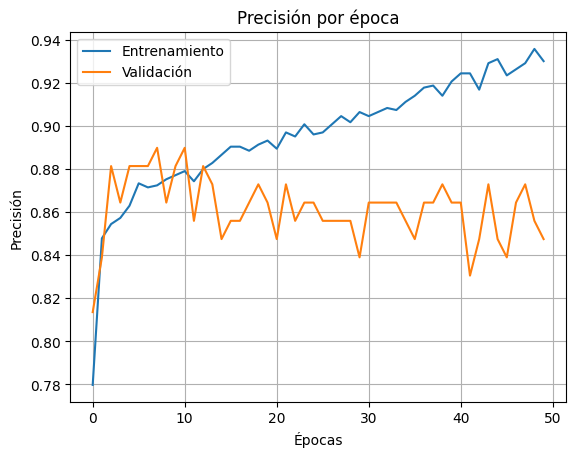

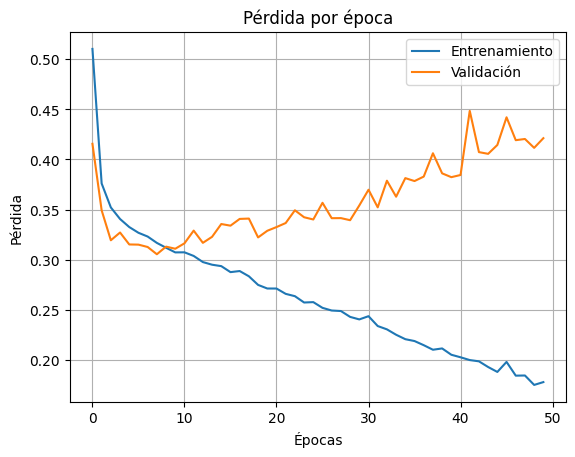

In [23]:
# Precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"Precisión final en test: {acc:.4f}, Pérdida: {loss:.4f}")

10/10 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.8435
Precisión final en test: 0.8435, Pérdida: 0.6231


In [25]:
model.save("modelo.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from tensorflow.keras.models import load_model

# Cargar el modelo
modelo = load_model("modelo.h5")
# Mostrar resumen de arquitectura
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3713 (14.50 KB)
Trainable params: 3713 (14.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
print("\nPrimeras filas de X_train escalado:")
print(pd.DataFrame(X_train_scaled, columns=X.columns).head())


Primeras filas de X_train escalado:
        Age  DistanceFromHome  Education  MonthlyIncome  NumCompaniesWorked  \
0  1.090194         -0.899915   1.064209       2.026752            1.330763   
1 -1.634828         -0.899915  -1.855332      -0.864408           -1.083704   
2  0.981193         -0.777610  -1.855332       2.347706            0.123529   
3 -1.307825          0.445433  -1.855332      -0.956202           -0.681293   
4  0.654191         -0.043784   2.037390      -0.185956            0.123529   

   TotalWorkingYears  YearsAtCompany  BusinessTravel_Non-Travel  \
0           2.261482       -0.665706                  -0.341773   
1          -1.072675       -0.830071                  -0.341773   
2           1.492061        0.813578                  -0.341773   
3          -0.559727       -0.008246                  -0.341773   
4          -0.175017        0.156119                  -0.341773   

   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  ...  \
0          

In [40]:
print("\nCaracterísticas (X) (primeras filas):")
print(X.head())
print(f"Forma de X: {X.shape}, Dtype de una columna de X: {X.iloc[:,0].dtype}")
print("\nVariable objetivo (y) (primeras filas):")
print(y.head())
print(f"Forma de y: {y.shape}, Dtype de y: {y.dtype}")


Características (X) (primeras filas):
   Age  DistanceFromHome  Education  MonthlyIncome  NumCompaniesWorked  \
0   41                 1          2           5993                   8   
1   49                 8          1           5130                   1   
2   37                 2          2           2090                   6   
3   33                 3          4           2909                   1   
4   27                 2          1           3468                   9   

   TotalWorkingYears  YearsAtCompany  BusinessTravel_Non-Travel  \
0                  8               6                          0   
1                 10              10                          0   
2                  7               0                          0   
3                  8               8                          0   
4                  6               2                          0   

   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  ...  \
0                                 0    